In [1]:
#all imports
import math as m
import numpy as np
import pandas as pd
import copy

In [2]:
#Define my class with all the information collected from each point

class Points():
    
    def __init__(self, params):
        self.name = params[0]
        self.x = int(params[5])
        self.y = int(params[6])
        self.pos = (self.x,self.y)
        self.x_drift = int(params[3])
        self.y_drift = int(params[4])
        self.group = params[7]
        self.explosion = params[8]

        if params[9] == "minimal":     #there is almost no noise
            self.noise = 0
        elif params[9] == "little":    #there is some noise, but not in the areas where I see peaks
            self.noise = 1
        elif params[9] == "a bit":     #there is some noise and could affect the peaks a little
            self.noise = 2
        else:
            self.noise = 3             #there is noise, but barely not enough for me to ignore the results

        self.pot_diff = (float(params[10]),float(params[11]))
        self.peaks = []

        leftovers = params[12::]
        for i in range(len(leftovers)):
            if leftovers[i] != '':
                self.peaks.append(float(leftovers[i]))
        
        #to use later when implementing a data submission form
        #self.x_original = params[1]     
        #self.y_original = params[2]
        #self.x = self.x_original - self.x_drift
        #self.y = self.y_original - self.y_drift

    def __repr__(self):
        return "Point " + self.name + " at position " + str(self.pos) + " with peaks " + str(self.peaks)
    
    def __str__(self):
        return "Point " + self.name
    
    def info(self):
        print( self.name + "\n" + "Position: " + str(self.pos) + '\n' + "Peaks: " + str(self.peaks) + '\n' + "Drift(x,y): " + '(' + str(self.x_drift) +','+ str(self.y_drift) + ')' + "   Noise level: " +str(self.noise) + "\n" + "Potential difference: " + str(self.pot_diff) + '\n' + "Explosion: " + self.explosion + "   Group: " + self.group + '\n' )
        return
    
    def __sub__(self,other):          #for distance between points
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    
    
class Defect():
    
    def __init__(self,params):
        self.name = params[0]
        self.x = params[1]
        self.y = params[2]
        self.pos = (self.x,self.y)

    def __sub__(self,other):          #for distance between point and the defect, for specific range graphing
        dist_x = self.x - other.x
        dist_y = self.y - other.y
        magnitude = m.sqrt(dist_x**2 + dist_y**2)
        return magnitude
    
    def __repr__(self):
        return self.name
    
    def __str__(self):
        return self.name + " at position " + str(self.pos)


In [60]:
samples = []

with open("Peak_data.csv") as file:
    for line in file:
        data = line.strip().split(',')
        try:
            if data[0][2] == '_':
                samples.append(Points(data))
        except:
            IndexError

sel_samples = copy.deepcopy(samples)           
            
#Testing out my imported data
print("length of samples list: ",len(samples))
test = samples[33]
print("print(test) --> ",test)
print("test.info() --> see below",'\n')
test.info()
#testing out defect and distance
defect_1 = Defect(['defect_1',850,2150])
print("Specify location of possible defect: ",defect_1)
dist = defect_1 - samples[33]
print("Find distance between point and the defect: ",dist)

length of samples list:  127
print(test) -->  Point 29_492
test.info() --> see below 

29_492
Position: (851, 2155)
Peaks: [0.7]
Drift(x,y): (-4,-37)   Noise level: 0
Potential difference: (0.0, 0.8)
Explosion: pre+   Group: 19

Specify location of possible defect:  defect_1 at position (850, 2150)
Find distance between point and the defect:  5.0990195135927845


In [71]:
#Alloted for data selection

def noise(sel_samples,noise):
    temp = []
    for point in sel_samples:
        if point.noise <= noise:
            temp.append(point)
    return temp

def explode(sel_samples, explosion):
    temp = []
    for point in sel_samples:
        if point.explosion == explosion:
            temp.append(point)
    return temp

def position(sel_samples, min_val, max_val):
    temp = []
    for point in sel_samples:
        if min_val <= point.y <= max_val:
            temp.append(point)
    return temp

def peaks(sel_samples,min_peak,max_peak):
    temp = []
    for point in sel_samples:
        for peak in point.peaks:
            if max_peak < peak or peak < min_peak:
                point.peaks.remove(peak)
                
        if len(point.peaks) > 0:
            for peak in point.peaks:
                if min_peak <= peak <= max_peak:
                    temp.append(point)
    return temp

def reset(samples):
    temp = copy.deepcopy(samples)
    return temp


In [48]:
#Alloted for Graphing
#To Do, non overlapping legend, work on more gradual color gradient, set third axes ticks invisible in side views
#%matplotlib notebook
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D

def scatter3(samples):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title('di/dv Peaks')
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('Peak')
    fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
    plt.yticks(np.arange(800,870,10))
    plt.xticks(np.arange(1925,2200,50))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    x = []
    y = []
    z = []

    for point in samples:
        for peak in point.peaks:
            x.append(point.x)
            y.append(point.y)
            z.append(peak)
    ax.scatter(y,x,z)
    plt.show()
    return

def scatter_color(samples):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title('di/dv Peaks')
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('Peak')
    fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
    plt.yticks(np.arange(800,870,10))
    plt.xticks(np.arange(1925,2200,50))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    for point in samples:
        for peak in point.peaks:
            if 0 < peak <= .3:
                color = 'm'
                name = '0 -.3'
                purple = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)

            elif .3 < peak <= .5:
                color = 'b'
                name = '.3 -.5'
                blue = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)

            elif .5 < peak <= .6:
                color = 'g'
                name = '.5 -.6'
                green = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            elif .6 < peak <= .7:
                color = 'y'
                name = '.6 -.7'
                yellow = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            elif .7 < peak <= .8:
                color = 'C1'
                name = '.7 -.8'
                orange = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            else:
                color = 'r'
                name = '.8 <'
                red = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.)
    ax.legend(handles=[red, orange, yellow, green, blue, purple])
    plt.show()
    return

def scatter_angle(samples,elevation):
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title('di/dv Peaks')
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('Peak')
    
    x = []
    y = []
    z = []

    for point in samples:
        for peak in point.peaks:
            x.append(point.x)
            y.append(point.y)
            z.append(peak)
    ax.scatter(y,x,z)
    
    for ii in range(0,360,1):
        ax.view_init(elev=elevation, azim=ii)
        
    if elevation == 0:
        plt.title('di/dv Peaks - Side View')
        fig.set_size_inches(16.5,8.5)     #18.5, 10.5)

    if elevation == -90:
        plt.title('di/dv Peaks - Above View')
        fig.set_size_inches(8.5,16.5)     #18.5, 10.5)
     
    plt.yticks(np.arange(800,870,10))
    plt.xticks(np.arange(1925,2200,50))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    plt.show()
    return

def scatter_color_angle(samples, elevation):

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    
    plt.title('di/dv Peaks')
    ax.set_xlabel('y')
    ax.set_ylabel('x')
    ax.set_zlabel('Peak')
    fig.set_size_inches(16.5,8.5)     #18.5, 10.5)
    plt.yticks(np.arange(800,870,10))
    plt.xticks(np.arange(1925,2200,50))
    plt.gca().invert_xaxis()
    plt.gca().invert_yaxis()
    
    for point in samples:
        for peak in point.peaks:
            if 0 < peak <= .3:
                color = 'm'
                name = '0 -.3'
                purple = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)

            elif .3 < peak <= .5:
                color = 'b'
                name = '.3 -.5'
                blue = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)

            elif .5 < peak <= .6:
                color = 'g'
                name = '.5 -.6'
                green = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            elif .6 < peak <= .7:
                color = 'y'
                name = '.6 -.7'
                yellow = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            elif .7 < peak <= .8:
                color = 'C1'
                name = '.7 -.8'
                orange = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
            else:
                color = 'r'
                name = '.8 <'
                red = ax.scatter(point.y, point.x, peak,'z',c = color, label = name)
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1.)
    ax.legend(handles=[red, orange, yellow, green, blue, purple])
    for ii in range(0,360,1):
        ax.view_init(elev=elevation, azim=ii)
        
    if elevation == 0:
        plt.title('di/dv Peaks - Side View')
    if elevation == -90:
        plt.title('di/dv Peaks - Above View')
    plt.show()
    return



#graph1 = scatter3(sel_samples)          #classic graph
#graph2 = scatter_color(sel_samples)     #colors separated by peak value
#graph3 = scatter_angle(sel_samples,-90)  #above view
#graph4 = scatter_angle(sel_samples,0)    #side view
#graph5 = scatter_color_angle(sel_samples,0)   #color side view

first graph, sets the graph_num value


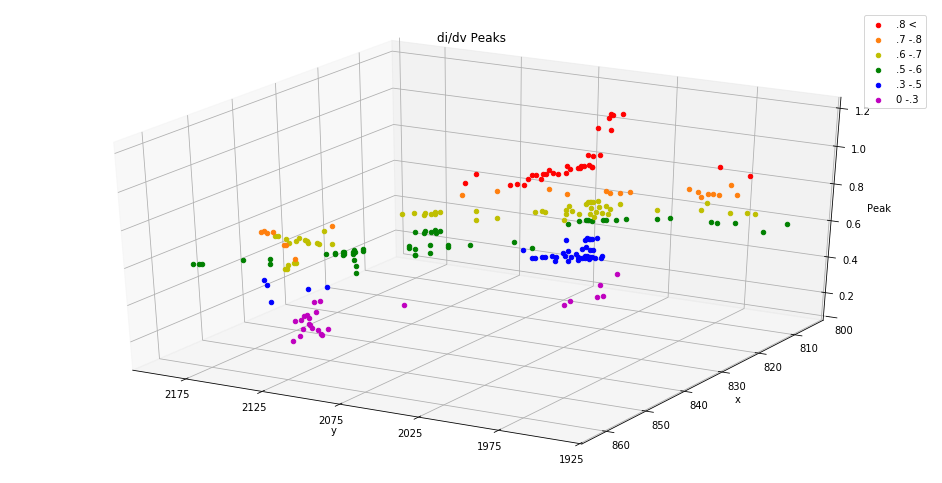

first refine, graphs with only minimal noise(noise level 0)


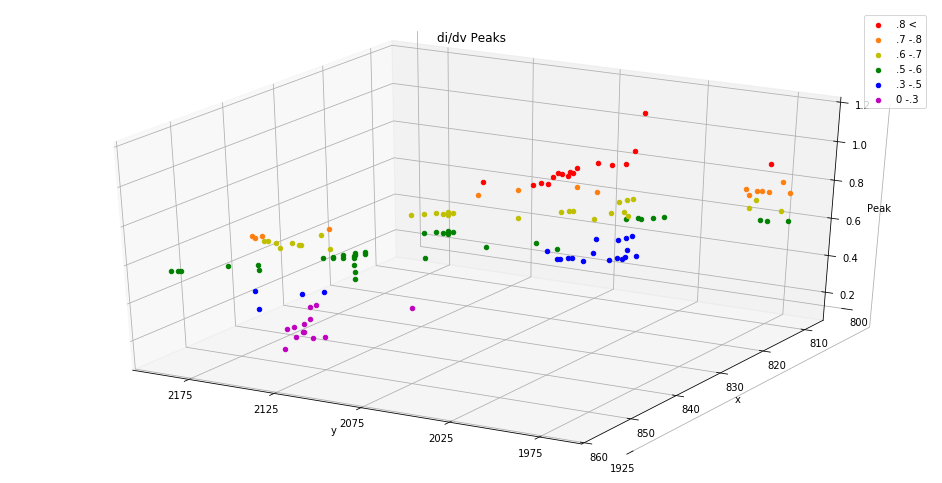

change graph type


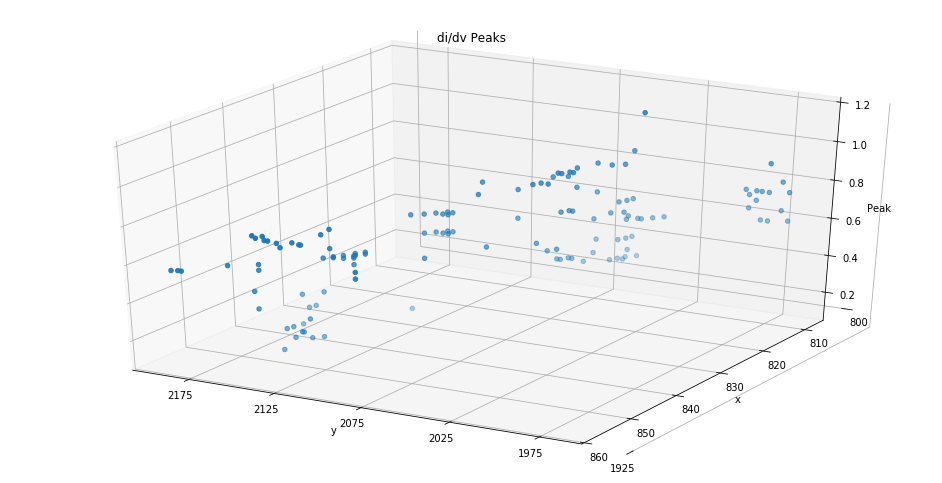

second refine, graphs only points before tip explosion


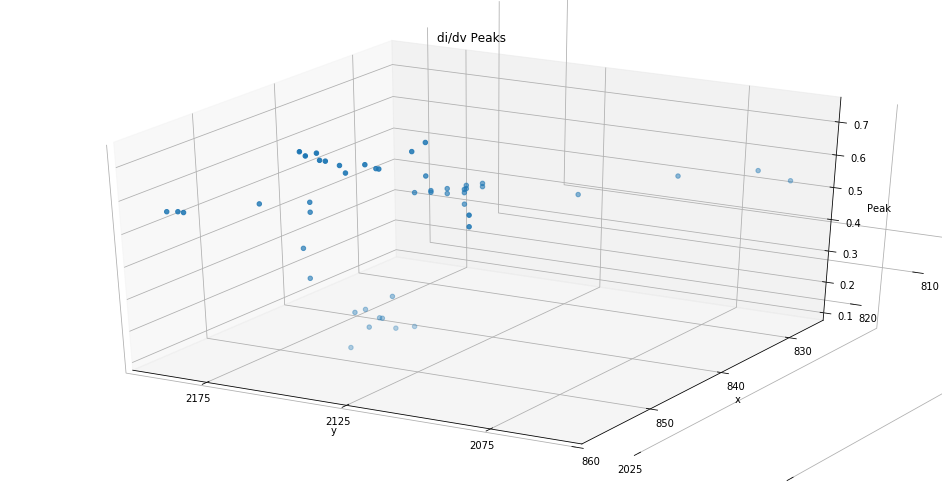

reset


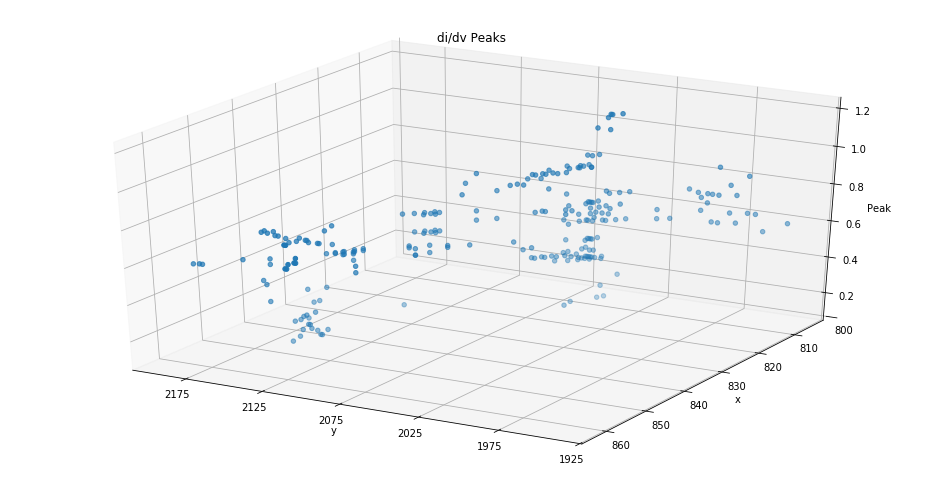

first refine, graphs only points in the range 2050 and 2025


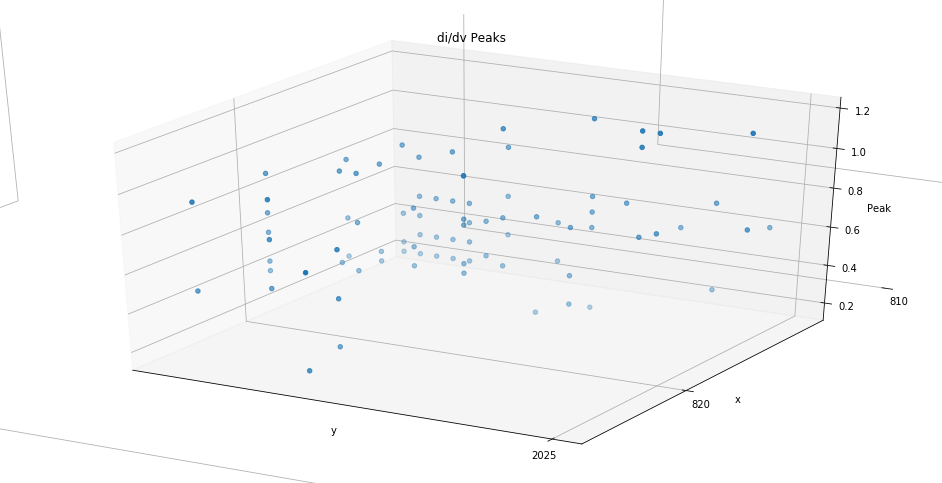

second refine, graphs only peaks in the range .5 and .6


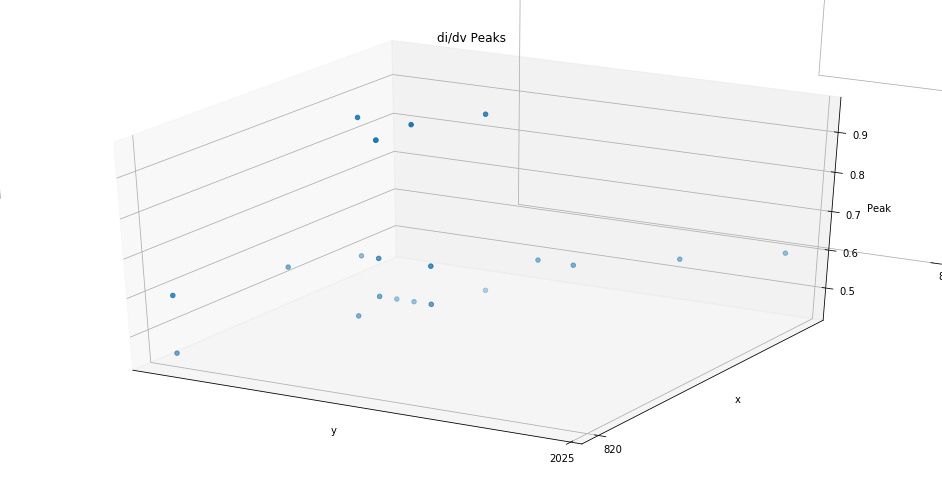

change graph angle


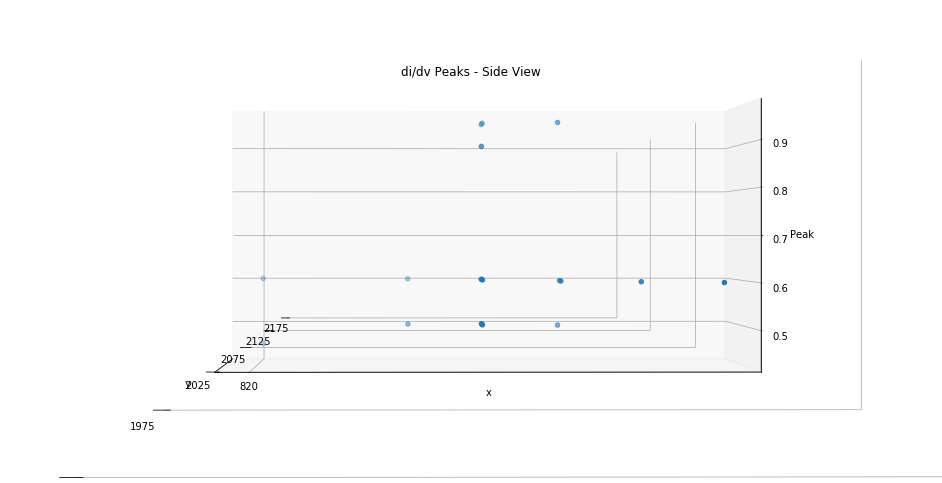

In [73]:
#Alloted for GUI testing
#
#current current_graph options;
#     1: classic graph
#     2: classic graph, colors separated by peak value
#     3: angle view, above view
#     4: angle view, side view
#     5: angle view with color, side view

from ipywidgets import widgets
from IPython.display import display

#starting places
graph_num = 0    
refine_num = 0
sel_samples = copy.deepcopy(samples)

def current_graph(graph_num,sel_samples):
    if graph_num == 1:
        graph = scatter3(sel_samples)
    elif graph_num == 2:
        graph = scatter_color(sel_samples)
    elif graph_num == 3:
        graph = scatter_angle(sel_samples,-90)
    elif graph_num == 4:
        graph = scatter_angle(sel_samples,0)
    elif graph_num == 5:
        graph = scatter_color_angle(sel_samples,0)
        
    return graph_num

#current refine options;
#     1:  noise
#     2:  explosion
#     3:  position
#     4:  peaks
#     5:  reset

def refine(refine_num,graph_num,sel_samples,x,y):
    if refine_num == 1:
        temp = noise(sel_samples,x)
        graph = current_graph(graph_num,temp)
    elif refine_num ==2:
        temp = explode(sel_samples,x)
        graph = current_graph(graph_num,temp)
    elif refine_num == 3:
        temp = position(sel_samples,x,y)
        graph = current_graph(graph_num,temp)
    elif refine_num == 4:
        temp = peaks(sel_samples,x,y)
        graph = current_graph(graph_num,temp)
    elif refine_num == 5:
        temp = reset(samples)
        graph = current_graph(graph_num,temp)
        
    return temp

#testing
print('first graph, sets the graph_num value')
graph_num = current_graph(2,sel_samples)
print('first refine, graphs with only minimal noise(noise level 0)')
sel_samples = refine(1,graph_num,sel_samples,0,0)
print('change graph type')
graph_num = current_graph(1,sel_samples)
print('second refine, graphs only points before tip explosion')
sel_samples = refine(2,graph_num,sel_samples,'pre+',0)
print('reset')
sel_samples = refine(5,graph_num,samples,0,0)
print('first refine, graphs only points in the range 2050 and 2025') #weird shape, but works, fix later
sel_samples = refine(3,graph_num,sel_samples,2025,2050)
print('second refine, graphs only peaks in the range .5 and .6')
sel_samples = refine(4,graph_num,sel_samples,.5,.6)
print('change graph angle')
graph_num = current_graph(4,sel_samples)

#fix scatter_color bug where if a point in a color range is never plotted, it can't be added to the graph

In [28]:
#Alloted for GUI
text = widgets.Text()
display(text)
def handle_submit(sender):
    print(text.value)
    
text.on_submit(handle_submit)

Widget Javascript not detected.  It may not be installed or enabled properly.


In [7]:
#Alloted for data storage

In [8]:
#Alloted for data submission

In [9]:
#Alloted for testing

In [10]:
#Alloted for holding code

#wireframe basics
#x = []
#y = []
#z = []
#x.append(point.x)
#y.append(point.y)
#z.append(peak)
#fig2 = plt.figure()
#ax2 = fig.add_subplot(111,projection='3d')
#ax2.plot_wireframe(x,y,z)

#for angle in range(0, 360):
#    ax.view_init(30, angle)
#    plt.draw()
#    plt.pause(.001)


In [11]:
#Alloted for testing